# Выбор локации для скважины

Датасеты содержат данные о геологических разведках нети в трех регионах (строками представлены скважины). Необходимо построить модель для определения региона, где добыча принесёт наибольшую прибыль, исходя из данных разведки заданных экономчиских параметров.

Условия выбора региона:
- При разведке региона необходимо исследовать 500 точек, из которых с помощью машинного обучения выбрать 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей (т.к. объём указан в тысячах баррелей).
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них необходимо выбрать регион с наибольшей средней прибылью.

Значения столбцов датасета:
- `f0`, `f1`, `f2` — три технических признака точек;
- `product` — объём запасов в скважине (тыс. баррелей)

## 1. Обзор данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler #Для стандартизации признаков

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

In [2]:
reg_1 = pd.read_csv('datasets/geo_data_0.csv')
reg_2 = pd.read_csv('datasets/geo_data_1.csv')
reg_3 = pd.read_csv('datasets/geo_data_2.csv')

Проверим датасеты на структуру и наличие дубликатов.

In [3]:
# Функция для описания датасета.

def show_info(df_name, df):
    print('Датасет', df_name, '\n')
    print(df.info(), '\n')
    print('Датасет содержит', df.duplicated().sum(), 'дубликатов.\n')
    
    for i in df.columns:
        print('Колонка', i, 'содержит', df[i].isna().sum(), 'пропусков.')
    
    display(df.head(5))
    display(df.describe())
    
    print('-'*100, '\n\n\n')

In [4]:
show_info(1, reg_1)
show_info(2, reg_2)
show_info(3, reg_3)

Датасет 1 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

Датасет содержит 0 дубликатов.

Колонка id содержит 0 пропусков.
Колонка f0 содержит 0 пропусков.
Колонка f1 содержит 0 пропусков.
Колонка f2 содержит 0 пропусков.
Колонка product содержит 0 пропусков.


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


---------------------------------------------------------------------------------------------------- 



Датасет 2 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

Датасет содержит 0 дубликатов.

Колонка id содержит 0 пропусков.
Колонка f0 содержит 0 пропусков.
Колонка f1 содержит 0 пропусков.
Колонка f2 содержит 0 пропусков.
Колонка product содержит 0 пропусков.


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


---------------------------------------------------------------------------------------------------- 



Датасет 3 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

Датасет содержит 0 дубликатов.

Колонка id содержит 0 пропусков.
Колонка f0 содержит 0 пропусков.
Колонка f1 содержит 0 пропусков.
Колонка f2 содержит 0 пропусков.
Колонка product содержит 0 пропусков.


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


---------------------------------------------------------------------------------------------------- 





Проверим распределенние данных в каждом столбце каждого датасета, чтобы определить, необходимо ли очищать их от выбросов.

In [5]:
# Функции для построения распределений и диаграм размаха.

def boxplot_values(df, item):
    upper_quartile = df[item].quantile(0.75)
    lower_quartile = df[item].quantile(0.25)
    median = df[item].median()
    mean = df[item].mean()
    iqr = upper_quartile - lower_quartile
    upper_whisker = df[item][df[item] <= upper_quartile + 1.5 * iqr].max()
    lower_whisker = df[item][df[item] >= lower_quartile - 1.5 * iqr].min()
    print('25-й процентиль:', lower_quartile)
    print('75-й процентиль:', upper_quartile)
    print('Медиана: ', median)
    print('Среднее: ', mean)
    print('Нижний ус:', lower_whisker)
    print('Верхний ус:', upper_whisker)

def hist_boxplot(df, item):
    df[item].hist(bins=200, figsize=(10, 4)).set(xlabel=item, ylabel='Запас скважины');
    plt.title('Распределение скважин по объемам запасов')
    plt.show()
    df.boxplot(column=item, vert=False, figsize=(10,4)).set(xlabel='Запас скважины');
    boxplot_values(df, item)

Рассмотрим распределение продуктивности скважин в регионе 1.

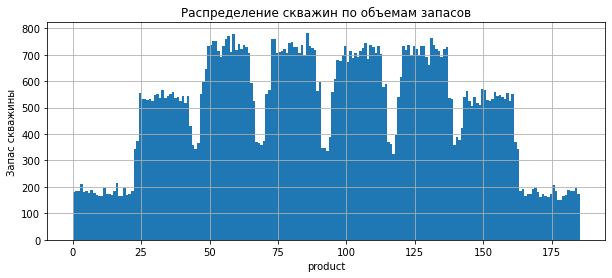

25-й процентиль: 56.497506659858026
75-й процентиль: 128.56408897150277
Медиана:  91.84997204396296
Среднее:  92.49999999999976
Нижний ус: 0.0
Верхний ус: 185.3643474222929


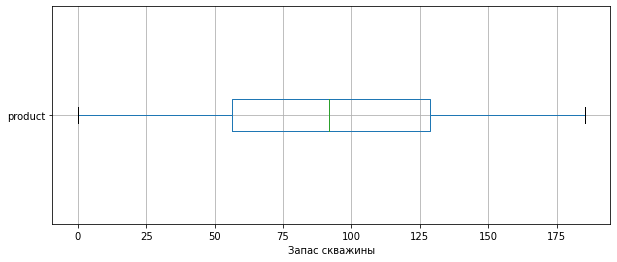

In [6]:
hist_boxplot(reg_1, 'product')

Рассмотрим распределение продуктивности скважин в регионе 2.

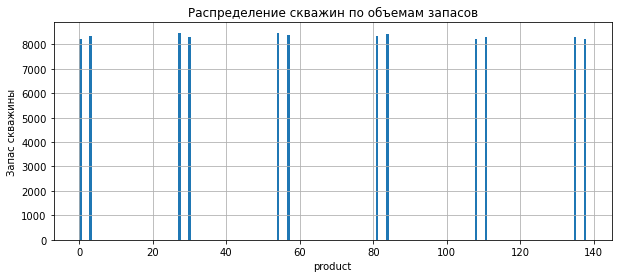

25-й процентиль: 26.953261031539693
75-й процентиль: 107.81304412615877
Медиана:  57.08562464628662
Среднее:  68.82500000002561
Нижний ус: 0.0
Верхний ус: 137.94540774090564


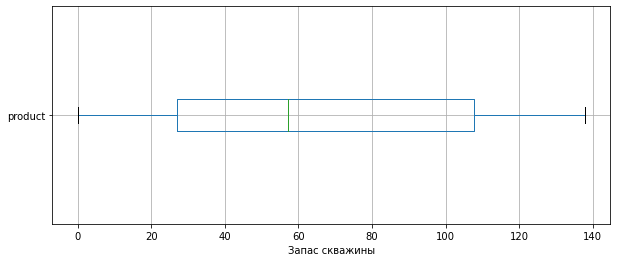

In [7]:
hist_boxplot(reg_2, 'product')

Рассмотрим распределение продуктивности скважин в регионе 3.

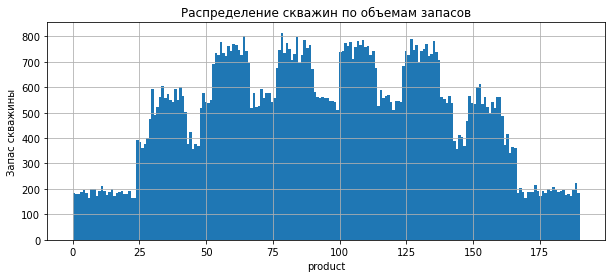

25-й процентиль: 59.45044093843896
75-й процентиль: 130.5950267155838
Медиана:  94.92561258990246
Среднее:  95.00000000000041
Нижний ус: 0.0
Верхний ус: 190.02983834335132


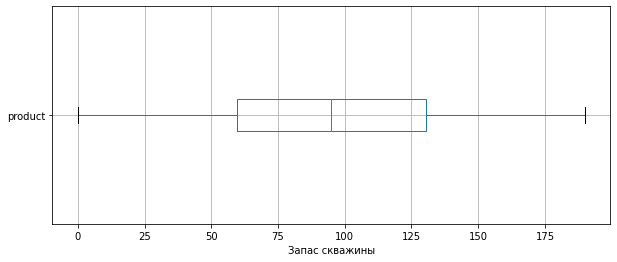

In [8]:
hist_boxplot(reg_3, 'product')

Распределение объема добычи скважин второго региона сильно отличается от первых двух и имеет самое низкое значение медианы (57 против >90) и других характеристик дескриптивной статистики.

## 2.  Обучение и проверка модели

Создадим единую функцию для составления выборок, нормализации данных, формирования линейной регрессии, а также формирования списков таргетов и предсказаний.

In [9]:
# Вспомогательная функция для получения названия региона.
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [10]:
# Переменные для внесения таргетов.
target_reg_1 = []
target_reg_2 = []
target_reg_3 = []

# Переменные для внесения предсказаний.
prediction_reg_1 = []
prediction_reg_2 = []
prediction_reg_3 = []

In [11]:
# Функция, формирующая линейную регрессию.
def linear_regression(df, target_list, result_list):
    
    df_name = get_df_name(df)
    
    # Выделим переменные и целевой признак.
    features = df.drop(['product', 'id'], axis=1)
    target = df['product']
    
    
    # Разделим выборки на обучающую и ваоидационную.
    (features_train,
     features_valid,
     target_train,
     target_valid) = train_test_split(features, target, test_size=0.25, random_state=12345)
    
    
    # Нормализуем переменные.
    scaler = StandardScaler().fit(features_train)
    features_train = pd.DataFrame(scaler.transform(features_train))
    features_valid = pd.DataFrame(scaler.transform(features_valid))
    
    
    # Запустим модель.
    model = LinearRegression()
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    
    # Оценим предсказание модели.
    mse = mean_squared_error(prediction, target_valid)
    print('Результат линейной регрессии региона', df_name)
    
    
    # Выведем сводку результатов модели.
    print(pd.Series(prediction).describe())
    print('\nСредний запас предсказанного сырья =', prediction.mean().round(2))
    print('MSE =', mse.round(2))
    print('RMSE=', (mse ** 0.5).round(2), '\n\n', '---'*20)
    
    
    # Для сохранения значений таргетов.
    for i in target_valid:
        target_list.append(i)
    
    # Для сохранения значений предсказания.
    for i in prediction:
        result_list.append(i)

    
    return 

Запустим функцию моделирования на 3 регионах.

In [12]:
linear_regression(reg_1, target_reg_1, prediction_reg_1)
linear_regression(reg_2, target_reg_2, prediction_reg_2)
linear_regression(reg_3, target_reg_3, prediction_reg_3)

Результат линейной регрессии региона reg_1
count    25000.000000
mean        92.592568
std         23.176994
min         -9.367846
25%         76.652232
50%         92.661884
75%        108.437632
max        180.180713
dtype: float64

Средний запас предсказанного сырья = 92.59
MSE = 1412.21
RMSE= 37.58 

 ------------------------------------------------------------
Результат линейной регрессии региона reg_2
count    25000.000000
mean        68.728547
std         46.010225
min         -1.893774
25%         28.536661
50%         57.851586
75%        109.346485
max        139.818970
dtype: float64

Средний запас предсказанного сырья = 68.73
MSE = 0.8
RMSE= 0.89 

 ------------------------------------------------------------
Результат линейной регрессии региона reg_3
count    25000.000000
mean        94.965046
std         19.853733
min         17.131597
25%         81.388500
50%         95.031204
75%        108.492663
max        165.856833
dtype: float64

Средний запас предсказанного сырья

Согласно резульатам предсказания модели, регионы 1 и 3 имеют на 30% большие запасы, чем регион 2 однако, ошибка прогноза в них также в десятки раз больше, чем на данных региона 2.

## 3.  Подготовка к расчёту прибыли

Найдем минимальный объем добычи из одной скважины при заданных параметрах.

In [13]:
# Общее число исследуемыех скважин в одном регионе
UNITS = 500

# Число скважин, которые нужно отобрать для разработки, в одном регионе
TOP_UNITS = 200

# Бюджет на разработку скважин одного региона
TOTAL_BUDGET = 10*(1000**3)

# Доход с тысячи баррелей, руб.
PRICE_PER_BARREL = 450*1000

# Допустимая вероятность убытка в регионе.
DAMAGE_FRESHOLD = 0.025


PROFITABLE_LIMIT = TOTAL_BUDGET/(TOP_UNITS*PRICE_PER_BARREL)
print('Минимальный необходимый объем добычи на одну скважину при заданном бюджете региона, тыс. баррелей:',
      round(PROFITABLE_LIMIT, 2))

Минимальный необходимый объем добычи на одну скважину при заданном бюджете региона, тыс. баррелей: 111.11


## 4.  Расчёт прибыли и рисков

Создадим функцию расчета доходности от разработки скважин региона, исходя из полученной модели и экономических показателей предыдущих пунктов исследования.

In [14]:
def revenue_calc(target, prediction, count):
    prediction = pd.Series(prediction)
    
    # Отбор топ-200 из предсказания по объему скважины.
    prediction_sorted = prediction.sort_values(ascending=False)[:count]
    
    # Отбор топ-200 скважин среди реально разведанных.
    top_units_target = target[prediction_sorted.index][:count]  
    
    # Доходность от топ-200 скважин региона минус бюджет.
    return (PRICE_PER_BARREL * top_units_target.sum()) - TOTAL_BUDGET

Создадим функцию рассчета средней прибыли, риска убытка от добычи и значений 95% доверительного интервала.

In [15]:
def bootstrap(target, prediction):
    state = np.random.RandomState(12345)
    values = []
    
    # Переменная для рассчета риска.
    risk_count = 0
    
    for i in range(1000):
        subset_target = target.sample(n=UNITS, replace=True, random_state=state)
        subset_prediction = prediction.loc[subset_target.index]
        
        revenue = revenue_calc(subset_target, subset_prediction, TOP_UNITS)
        values.append(revenue)
        
        if revenue<0:
            risk_count += 1
            
    risk = risk_count / 1000
    
    values = pd.Series(values)
    
    lower = round(values.quantile(0.025), 2)
    upper = round(values.quantile(0.975), 2)
    
    
    print('Средняя прибыль составляет:', '{0:,}'.format(values.mean()),
          'с риском в', round(risk * 100, 2), '%')
    print('Доверительный интервал находится в диапазоне от', '{0:,}'.format(lower),
          'до', '{0:,}'.format(upper))

Рассчитаем среднюю прибыль, риски и 95% доверительный интервал для каждого региона.

In [16]:
# Первый регион.
bootstrap(pd.Series(target_reg_1), pd.Series(prediction_reg_1))

Средняя прибыль составляет: 425,938,526.910592 с риском в 6.0 %
Доверительный интервал находится в диапазоне от -102,090,094.84 до 947,976,353.36


In [17]:
# Второй регион.
bootstrap(pd.Series(target_reg_2), pd.Series(prediction_reg_2))

Средняя прибыль составляет: 515,222,773.44329005 с риском в 1.0 %
Доверительный интервал находится в диапазоне от 68,873,225.37 до 931,547,591.26


In [18]:
# Третий регион.
bootstrap(pd.Series(target_reg_3), pd.Series(prediction_reg_3))

Средняя прибыль составляет: 435,008,362.78275585 с риском в 6.4 %
Доверительный интервал находится в диапазоне от -128,880,547.33 до 969,706,954.18


**Вывод**

Разработанная модель линейной регрессии указывает, что регион 1 имеет наименьшую потенциальную прибыль от вложений в разработку 200 наиболее продуктивных скважин: при достаточно большом риске (6%), средняя прибыль скважины составит 426 млн. руб.

Регион 3 обладает потенциалом прибыли лишь на 2% выше, региона 1 (средняя прибыль от инвестиций в топ-200 скважин составляет 435 млн. руб.), риски при чуть больших рисках - убыточные скважины не привысят 6,4% от объема разработки.

Регион 2 имеет самый выской потенциал в размере средней прибыли на скважину в 515 млн. руб. (на 21%, чем в регионах 1 и 3), однако. При этом, число скважин, которые не покроют расходы на разработку, достаточно низкое (1%).
Распределение доходности скважин также выглядит привлекательней, чем двух других регионах: в нижнем 2,5-процентиле распределения, доходность положительна, что также говорит о меньших рисках разработки в регионе 2.

Таким образом, с точки зрения рисков и ожидаемой доходности, регион 2 является наиболее привлекательным среди трех расмотренных.